# Project Proposal
#### Authors: Omer Tahir, Sam Zheng, Paul Huang, Longfei Guan
#### Group: 9

## Introduction

Substance testing takes on many practical applications in modern society whether it be forensics, sports integrity, medicinal research (cite). Acts such as distinguishing and  determining presence of substances is undoubtedly an essential technique in improving society that draws upon many scientific disciplines namely chemistry and statistics. 
  
Acknowledging the complexity of existent modern techniques which can vary on context and application, this report aims to use statistical inference to differentiate two groups of wine - red and white. Evidently, in a real life scenario this would be as simple as a colour comparison; however, the goal is to prove potential differences in qualities can be statistically detected between similar substances. Understanding statically proven differences –treating existing data as a training set - is beneficial and subsequently be applied to distinguish substances in fields such as forensics.
  
The data sets which will be used for this report is the Wine Quality Data Set from UCI machine learning repository. Notable quantitative variables include fixed acidity, volatile acidity, citric acidity, residual sugar, chlorides, total sulfur dioxide, density, pH, and quality. 
  
Out of all the given variables, we choose the following three as our variables of interest:
 
1. `Volatile acidity` (VA):  One of the chemicals produced during the production which smells and tastes like vinegar. Although there is not any evidence showing that VA is harmful to a human's body, many countries have restricted the VA concentration's limits in order to assure the quality of the wine.
  
2. `Alcohol`: A key element that explains the rich flavors and tastes of wines. It makes the wine taste bitter, sour, sweet, and spicy all together. Wines with a higher alcohol content tend to taste bolder and more oily.
  
3. `Sulfur Dioxide`: Mainly added to kill bacteria and prevent oxidation of the wine. It can naturally occur during the wine production process without artificial add. Too much sulfur dioxide in the wine will kill good yeast and give out undesirable odor and bitter taste.

Likewise, our research question is:  
**Does alcohol, sulfur dioxide, and volatile acidity differ between red and white wine?**

In the full report, after investigating the relevance of these variables in relation to the wine groups, we plan to validate our findings with existing research on general health differences surrounding the two wines. Connecting the results of our hypothesis test to the broader picture will allow for a greater contextual understanding.

## Preliminary Results

### Loading relevant libraries

In [12]:
library(tidyverse)
library(infer)
library(ggcorrplot)
library(knitr)

### Reading & Wrangling the datasets from the web into R

* Since we were dealing with 2 data sets, it was decided to read both the data sets separately and then merge them into a single dataframe called `wine_data`.
* Before merging, a new column was created called `type` in order to differentiate the white wine data with the red wine after the merge.
* After merging, the `type` and `quality` variables were converted into a factor as these are categorical/discrete variables.


In [3]:
# prepare urls
url_1 <- "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
url_2 <- "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"

# read redwine data
redwine_data <- 
    read.csv(url_1, sep=';') |>
    mutate(type = "red")

# read whitewine data
whitewine_data <- 
    read.csv(url_2, sep=';') |>
    mutate(type = "white")

# merge the two data sets using rbind()
wine_data <-  
    rbind(redwine_data, whitewine_data) |> 
    select(type, fixed.acidity:quality) |>
    mutate(quality = as_factor(quality),
           type = as_factor(type))

head(wine_data)

,type,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,red,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
2,red,7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5
3,red,7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5
4,red,11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6
5,red,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
6,red,7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5


### Exploratory Data Analysis

* We begin by checking for correlations for all the variables.
* This will help us visualize how the 3 variables we plan on using are related to the `type` variable.

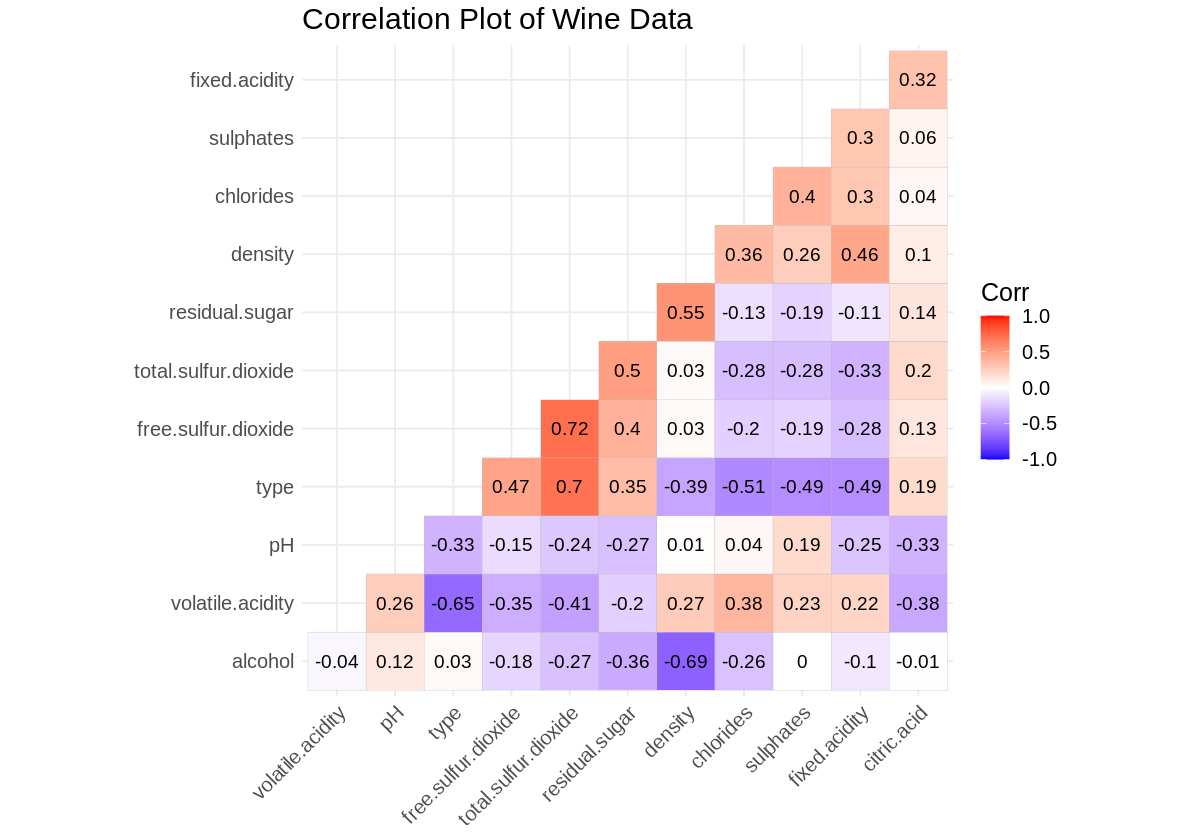

In [4]:
options(repr.plot.width = 10, repr.plot.height = 7)

to_binary <- function(x) {
    if(x == "red") {
        return(0)
    } else {
        return(1)
    }
}

r <- wine_data |>
    mutate(type = sapply(wine_data$type, to_binary)) |>
    select(type:alcohol) |>
    cor(use="complete.obs")|> 
    round(2)

ggcorrplot(r, 
           hc.order = TRUE, 
           type = "lower",
           lab = TRUE) +
    labs(title = "Correlation Plot of Wine Data") +
    theme(text = element_text(size = 15))

* It is observed that `alcohol` has little to no correlation with `type`. On the other hand, `total.sulfur.dioxide` has the largest positive correlations with `type` while `volatile.acidity` has the largest negative correlations with `type`. This further convinces us that at least two of the three selected variables must be further analyzed as the different type of wine may have a significantly different composition based on these variables.

* Now we check to see how each of these selected variable is distributed across each type of wine.
* With the help of histograms, we can visualize these distributions.

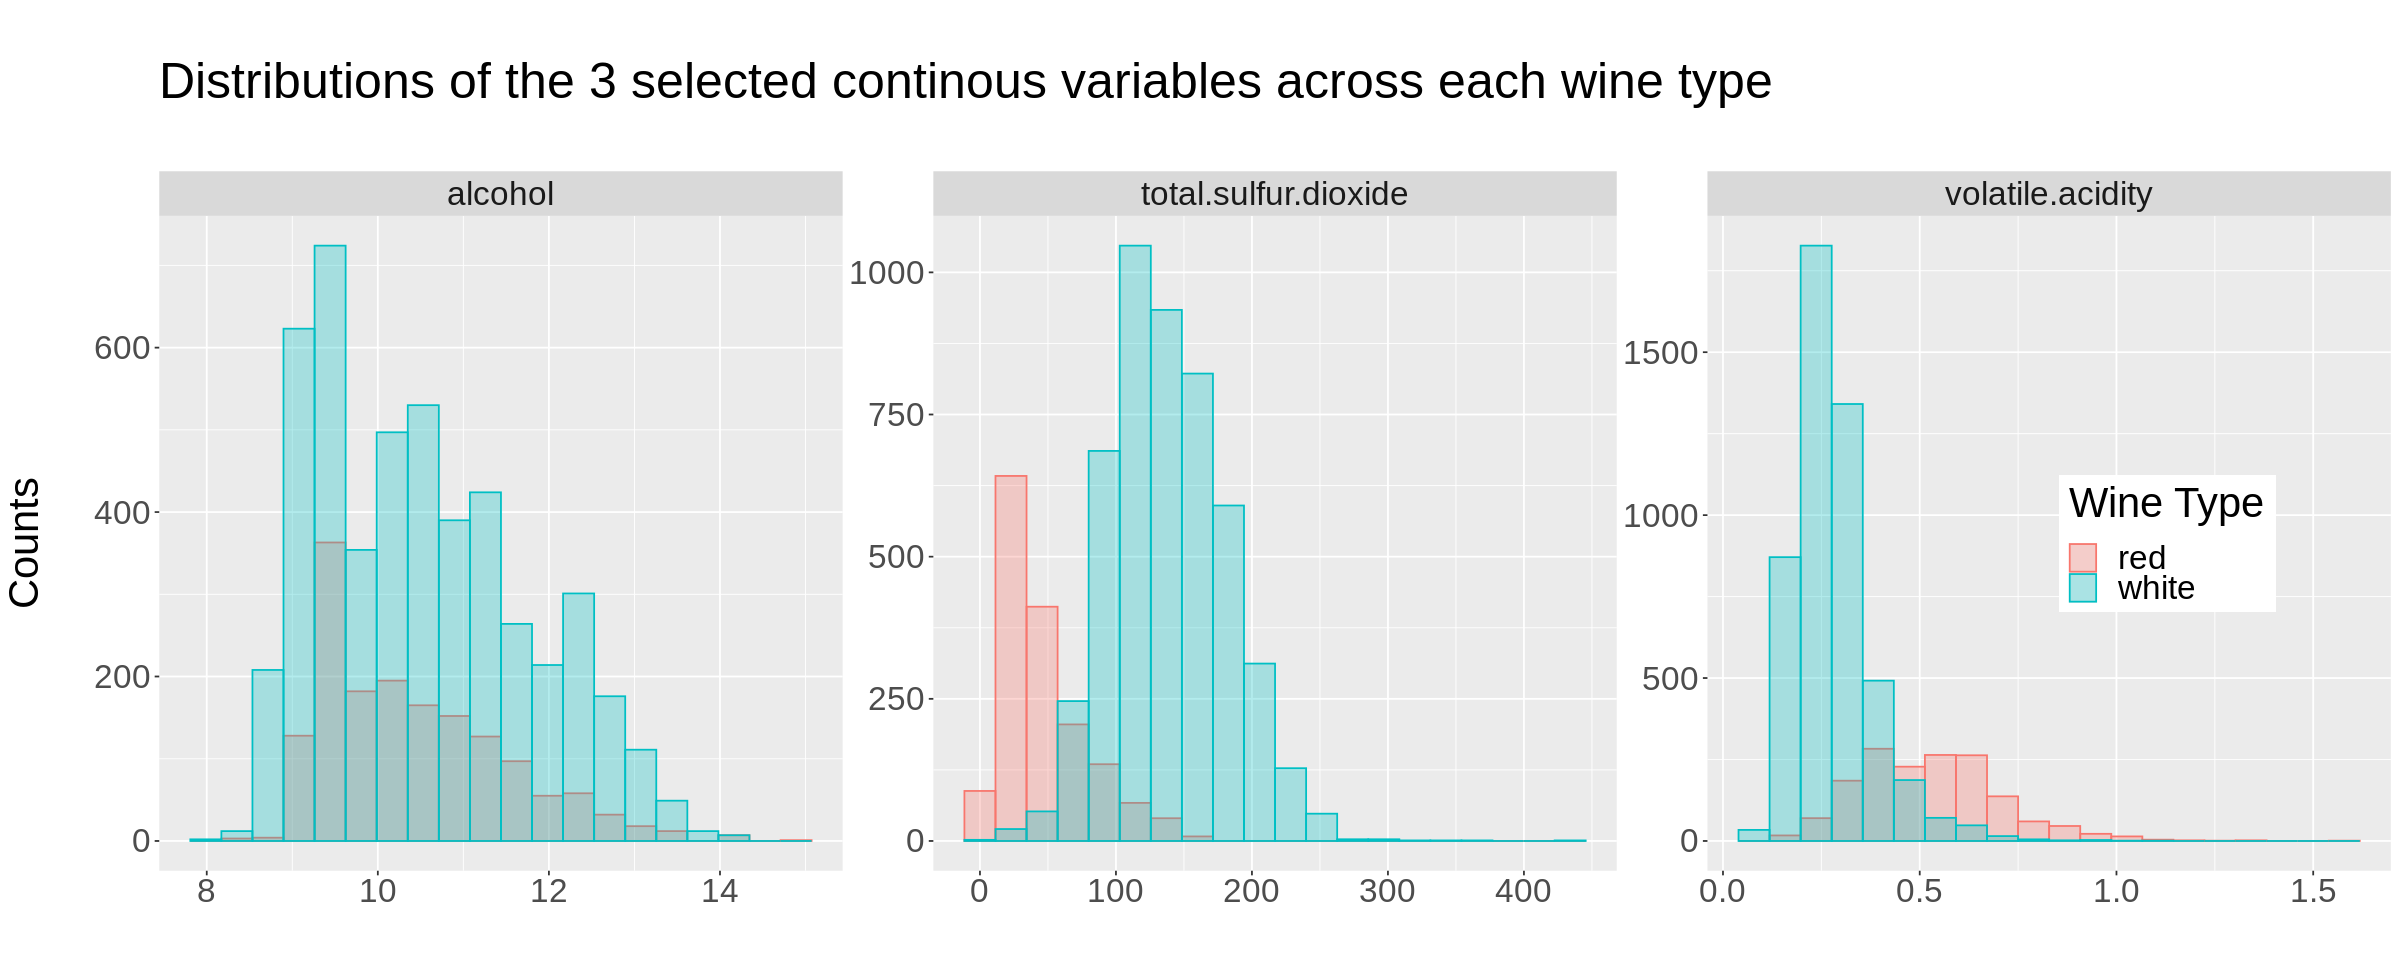

In [5]:
options(repr.plot.width = 20, repr.plot.height = 8)

wine_data |> 
    select(type,
           alcohol,
           total.sulfur.dioxide,
           volatile.acidity) |>
    pivot_longer(cols = -type,
                names_to = "response",
                values_to = "values") |>
    ggplot(aes(x = values, fill = type, colour = type)) +
    geom_histogram(alpha = 0.3, position = 'identity', bins = 20) +
    labs(x = "",
         y = "Counts\n",
         fill = "Wine Type",
         colour = "Wine Type",
         title = "\nDistributions of the 3 selected continous variables across each wine type\n") +
    facet_wrap(vars(response),
               scales = "free") +
    theme(text = element_text(size = 25),
          legend.position = c(0.90, 0.50))

* Since we want to check how each of these variables responds to the type of wine, we choose the expected difference as the parameter to be estimated.

In [15]:
## Obtain the test statistic (difference in means)
mean_diff_alcohol <- 
    wine_data |>
    specify(formula = alcohol ~ type) |>
    calculate(stat = "diff in means", order = c("red", "white")) |>
    pull()

mean_diff_sulfur <- 
    wine_data |>
    specify(formula = total.sulfur.dioxide ~ type) |>
    calculate(stat = "diff in means", order = c("red", "white")) |>
    pull()

mean_diff_acidity <- 
    wine_data |>
    specify(formula = volatile.acidity ~ type) |>
    calculate(stat = "diff in means", order = c("red", "white")) |>
    pull()

obs_diff_in_means <- tibble(variable =c("Alcohol Content", "Total Sulfur Dioxide", "Volatile Acidity"),
                                   mean.diff = c(mean_diff_alcohol, mean_diff_sulfur, mean_diff_acidity))



|Response Variable    |   Mean.Diff|
|:--------------------|-----------:|
|Alcohol Content      |      -0.091|
|Total Sulfur Dioxide |     -91.893|
|Volatile Acidity     |       0.250|



## Methods: Plan

At this point of the analysis, we only know the expected difference for each of the continuous (response) variables across the wine types. Nevertheless, using the estimates on their own does not provide much information to us. In other words, we do not know of these expected differences are significant or not. In addition, if these estimates were provided to an individual, one would ask how reliable or accurate these estimates are. In order to tackle these issues we will conduct hypothesis tests to check whether the expected difference for each of the three continuous variables is zero across the two different wine types. Therefore, our null hypotheses would state that the expected differences are zero while the alternative would be that the expected differences are not equal to zero. We intend to apply two methods to help us conduct our tests:
1. Perform bootstrapping on a sample size of 50 for each wine type in order to analyze the sampling distributions and obtain the respective 95% confidence interval. We will also observe statistics like mean values, median values and standard errors to make comparisons.
2. Use asymptotics to create confidence intervals as well as check for the significance of the results. 

We expect that two wines will have different amount of VA, alcohol, and sulfur dioxide. Thus, our aim is to provide results that will give an explanation to why red wine is more popular than white wine and how they differ in their composition regarding the following variables: VA, alcohol, and sulfur dioxide. 
  
Some future questions are:

* What are the potential reasons that make one wine healthier than the other wine?

* What are the factors that determine the quality of the wine?

* Do alcohol level affect the popularity of the wine?


## References

P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis.
Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

Gleason, J. G., & Barnum, D. B. (1991, January). RISK: Health, Safety & Environment (1990–2002). Https://Scholars.Unh.Edu/Cgi/Viewcontent.Cgi?Article=1038&context=risk&httpsredir=1&referer=#:~:text=That%20is%2C%20for%20the%20population,Positive%20for%20drugs%20is%200.013.

Harper, L. (2017, July 31). An overview of forensic drug testing methods and their suitability for harm reduction point-of-care services - Harm Reduction Journal. BioMed Central. https://harmreductionjournal.biomedcentral.com/articles/10.1186/s12954-017-0179-5

